In [3]:
# Iterative Mud Notebook
import logging
import pdb
import pickle
from datetime import datetime
from pathlib import Path

# Plotting libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from IPython.display import Image
import mud.pca as pca
from mud.base import DensityProblem
from mud.funs import iterative_mud_problem, wme
from mud.pde import PDEProblem

# Mud libraries
from mud.util import add_noise
from pyadcirc.io import read_fort222
from pyadcirc.viz import generate_gif as gg
from scipy.stats import distributions as dist
from scipy.stats import gaussian_kde as gkde
from scipy.stats import norm, uniform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

_logger = logging.getLogger(__name__)

%matplotlib widget

In [4]:
figs = {}

# ODE - Exponential Decay - Single Parameter Estimation Problem 
Consider an exponential decay system with uncertain paramater $\lambda$, which we model with the following differential equation.

\begin{equation}
\Large
\begin{cases} \frac{\partial u}{\partial t} = \lambda u(t), 0 \lt t \leq 3, \\
                  u(0) = 0.75
\end{cases}
\end{equation}

The true solution is given by the following equation. 
    
\begin{equation}
\Large u(t; \lambda) = u_0 \text{exp}(-\lambda t), u_0 = 0.75 
\end{equation}

In [8]:
def exp_decay_1D(
    u_0=0.75,
    time_range=[0, 4.0],
    domain=[0, 1],
    num_samples=10000,
    lambda_true=0.5,
    t_start=0.0,
    sampling_freq=100.0,
    std_dev=0.05,
):
    u_t_lambda = lambda t, l: u_0 * np.exp(-np.outer(l, t))

    # Build initial samples
    initial = uniform(loc=domain[0], scale=domain[1] - domain[0])

    exp_decay = PDEProblem()
    exp_decay.domain = domain
    exp_decay.times = np.arange(t_start, time_range[1], 1 / sampling_freq)
    exp_decay.sample_dist = "u"
    exp_decay.lam = initial.rvs(size=num_samples)
    exp_decay.data = u_t_lambda(exp_decay.times, exp_decay.lam)
    exp_decay.true_vals = u_t_lambda(exp_decay.times, lambda_true)[0]
    exp_decay.std_dev = std_dev

    return exp_decay

# ODE - Exponential Decay - Two  Parameter Problem
Consider an exponential decay system with uncertain paramater $\lambda$, which we model with the following differential equation.

\begin{equation}
\Large
\begin{cases} \frac{\partial u}{\partial t} = \lambda_1 u(t), 0 \lt t \leq 3, \\
                  u(0) = \lambda_0
\end{cases}
\end{equation}

The true solution is given by the following equation. 
    
\begin{equation}
\Large u(t; \lambda_0,; \lambda_1) = \lambda_0 \text{exp}(-\lambda_1 t)
\end{equation}

In [9]:
def exp_decay_2D(
    time_range=[0, 3.0],
    domain=np.array([[0.7, 0.8], [0.25, 0.75]]),
    num_samples=100,
    lambda_true=[0.75, 0.5],
    N=100,
    t_start=0.0,
    sampling_freq=10.0,
    std_dev=0.05,
):
    u_t_lambda = lambda t, l1, l2: (l1 * np.exp(-np.outer(t, l2))).T

    # Build initial samples
    num_params = domain.shape[0]
    mn = np.min(domain, axis=1)
    mx = np.max(domain, axis=1)
    initial = uniform(loc=mn, scale=mx - mn)

    exp_decay = PDEProblem()
    exp_decay.domain = domain
    exp_decay.times = np.arange(t_start, time_range[1], 1 / sampling_freq)[0:N]
    exp_decay.sample_dist = "u"
    exp_decay.lam = initial.rvs(size=(num_samples, num_params))
    exp_decay.data = u_t_lambda(
        exp_decay.times, exp_decay.lam[:, 0], exp_decay.lam[:, 1]
    )
    exp_decay.true_vals = u_t_lambda(exp_decay.times, lambda_true)[0]
    exp_decay.std_dev = std_dev

    return exp_decay

In [10]:
def scan_n_data_points(
    prob_type="1D",
    exp_kwargs={},
    method="wme",
    pca_components=1,
    N_trials=10,
    N_vals=list(range(5, 100, 5)),
):
    if prob_type == "1D":
        exp_decay = exp_decay_1D(**exp_kwargs)
    elif prob_type == "2D":
        exp_decay = exp_decay_2D(**exp_kwargs)
    else:
        raise ValueError(f"Invalid prob type {prob_type}")

    res = np.zeros((len(N_vals), 4))
    for i, N in enumerate(N_vals):
        print(f"Solving using {N}")
        times_idxs = np.arange(0, N)
        mud_ests = []
        r_vals = []
        for j in range(N_trials):
            # Take new set of noise measurments per trial
            exp_decay.measurements_from_reference()
            mud_prob = test.mud_problem(method=method, pca_components=pca_components)
            mud_ests.append(mud_prob.estimate())
            r_vals.append(mud_prob.exp_r())

        res[i][0] = np.mean(mud_ests)
        res[i][1] = np.var(mud_ests)
        res[i][2] = np.mean(r_vals)
        res[i][3] = np.var(r_vals)

    return res

### Goal and assumptions
Our goal is to use any initial knowledge on our parameter space, the assumed exponential decay model above, and data collected from experiments on the real world system to infer the true value $\lambda$, which we set for this example problem to $\lambda^{\dagger}=0.5$. We seek a point estimate of the this true value.

The main assumption we make is that our model is indeed an accurate representation of the physical system we are measuring, and the uncertainties in our experiments are aleatoric, i.e. reducible. Thus we have a noisy measurement device $M(t;\lambda^{\dagger})$ to record the true signal $u(t;\lambda^{\dagger})$ at $N$ points in time, with errors being idenpendent identically distributed Gaussain errors. The data collected can then be described by:

<center>
    \begin{equation}
        \label{eq:d_i}
        \Large d(t_i) = M(t_i, \lambda^{\dagger}) + \xi_i, \xi_i \sim {\mathcal N}(0, \sigma^2), 1 \leq i \leq N
    \end{equation}
</center>

Our goal is to use any initial knowledge on our parameter space, the assumed exponential decay model above, and data collected from our measurement device to infer the true value $\lambda^{\dagger}$. We will do this by building a Quantity of Interest map $Q$ from our observed data and perform data-consistent inversion to compute the updated probability density on our parameter space, given by the following equation

<center>
    \begin{equation}
        \Large
        \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pr}(Q(\lambda))}
    \end{equation}
</center>

Here $\pi_{pr}(Q(\lambda))$ corresponds to the push-forward of the initial distribution on our parameter space through the QoI map, while $\pi_{ob}(Q(\lambda))$ is the observed distribution of the QoI map for our system. From the $\pi_{up}(\lambda)$ we can then compute the <bf>Maximal Updated Density</bf> (MUD) point as

<center>
    \begin{equation}
        \Large
        \lambda^{MUD} := \text{argmax}\pi_{up}(\lambda)
    \end{equation}
</center>

Finall for our model problem, we assume our parameter range to be $\Lambda = [0,1]$ and a uniform initial distribution, $\pi_{in}(\lambda)={\mathcal U}([0,1])$.

In [11]:
test = exp_decay_1D()
test.plot_ts()

AttributeError: 'PDEProblem' object has no attribute 'n_params'

### No PCA

In [14]:
base = exp_decay_1D()
mud_prob = base.mud_problem(times_idx=np.arange(10, 70))
mud_prob.estimate(), mud_prob.exp_r()

(array([0.42533502]), 0.8687635798407409)

### Using PCA

In [9]:
test = exp_decay_1D()
mud_prob = test.mud_problem(method="pca", pca_components=1)
mud_prob.estimate(), mud_prob.exp_r()

(array([0.504703]), 0.9070204802156437)

#### Varying number of data points used

In [106]:
def scan_n_data_points(
    prob_type="1D",
    exp_kwargs={},
    method="wme",
    pca_components=1,
    N_trials=10,
    N_vals=list(range(5, 100, 5)),
):
    res = np.zeros((len(N_vals), 4))
    for i, N in enumerate(N_vals):
        print(f"Solving using {N}")
        times_idxs = np.arange(0, N)
        mud_ests = []
        r_vals = []
        for j in range(N_trials):
            if prob_type == "1D":
                exp_decay = exp_decay_one(**exp_kwargs)
            elif prob_type == "2D":
                exp_decay = exp_decay_two(**exp_kwargs)
            else:
                raise ValueError(f"Invalid prob type {prob_type}")
            mud_prob = test.mud_problem(method=method, pca_components=pca_components)
            mud_ests.append(mud_prob.estimate())
            r_vals.append(mud_prob.exp_r())

        res[i][0] = np.mean(mud_ests)
        res[i][1] = np.var(mud_ests)
        res[i][2] = np.mean(r_vals)
        res[i][3] = np.var(r_vals)

    return res

In [99]:
test = scan_n_data_points()

Solving using 5
Solving using 10
Solving using 15
Solving using 20
Solving using 25
Solving using 30
Solving using 35
Solving using 40
Solving using 45
Solving using 50
Solving using 55
Solving using 60
Solving using 65
Solving using 70
Solving using 75
Solving using 80
Solving using 85
Solving using 90
Solving using 95


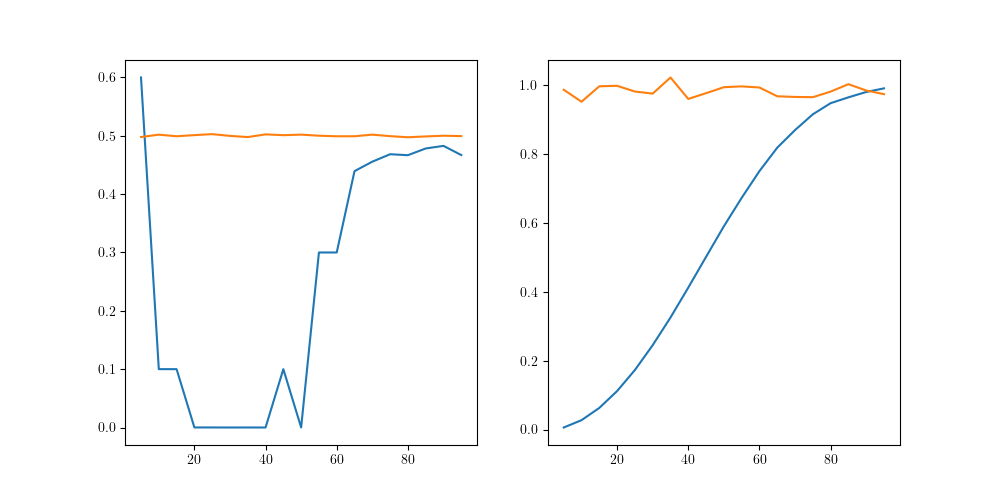

In [102]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(N_vals, res[:, 0])
plt.plot(N_vals, res_pca[:, 0])


ax = fig.add_subplot(1, 2, 2)
plt.plot(N_vals, res[:, 1])
plt.plot(N_vals, res_pca[:, 1])

## Exp Decay - Two Parameter Problem

In [251]:
def exp_decay_two(
    time_range=[0, 3.0],
    domain=np.array([[0.7, 0.8], [0.25, 0.75]]),
    num_samples=100,
    lambda_true=[0.75, 0.5],
    N=100,
    t_start=0.0,
    sampling_freq=10.0,
    std_dev=0.05,
):
    u_t_lambda = lambda t, l1, l2: (l1 * np.exp(-np.outer(t, l2))).T

    # Build initial samples
    num_params = domain.shape[0]
    mn = np.min(domain, axis=1)
    mx = np.max(domain, axis=1)
    initial = uniform(loc=mn, scale=mx - mn)

    exp_decay = PDEProblem()
    exp_decay.domain = domain
    exp_decay.times = np.arange(t_start, time_range[1], 1 / sampling_freq)[0:N]
    exp_decay.sample_dist = "u"
    exp_decay.lam = initial.rvs(size=(num_samples, num_params))
    exp_decay.data = u_t_lambda(
        exp_decay.times, exp_decay.lam[:, 0], exp_decay.lam[:, 1]
    )
    exp_decay.measurements_from_reference(
        u_t_lambda(exp_decay.times, lambda_true[0], lambda_true[1]), std_dev
    )

    return exp_decay

/var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_78962/3404322971.py:354: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 5))


<AxesSubplot:>

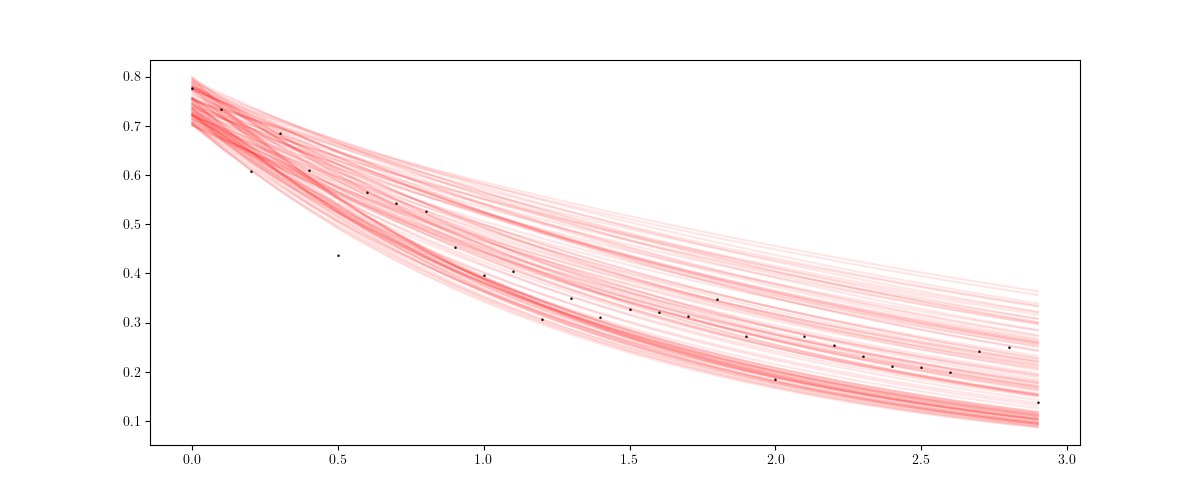

In [254]:
test_2d = exp_decay_two()
test_2d.plot_ts()

In [2]:
mud_prob_2d = test_2d.mud_problem()
mud_prob_2d.estimate(), mud_prob_2d.exp_r()

NameError: name 'test_2d' is not defined

In [1]:
mud_prob_2d.plot_param_space()

NameError: name 'mud_prob_2d' is not defined

In [248]:
mud_prob_2d_pca1 = test_2d.mud_problem(method="pca", pca_components=1)
mud_prob_2d_pca1.estimate(), mud_prob_2d_pca1.exp_r()

(array([0.74570147, 0.48567114]), 1.0357177206009511)

In [249]:
mud_prob_2d_pca2 = test_2d.mud_problem(method="pca", pca_components=2)
mud_prob_2d_pca2.estimate(), mud_prob_2d_pca2.exp_r()

(array([0.75505032, 0.38248748]), 1.7809608314382621)